<a href="https://colab.research.google.com/github/afiaka87/clip-guided-diffusion/blob/main/cgd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CLIP Guided Diffusion 

**From [RiversHaveWings](https://twitter.com/RiversHaveWing)**

Generate vibrant and detailed images using only text.
- Originally by Katherine Crowson (https://github.com/crowsonkb, https://twitter.com/RiversHaveWings). 
- Python repository and additions assembled by Clay Mullis (https://github.com/afiaka87)

**[Read Me](https://github.com/afiaka87/clip-guided-diffusion)**

In [ ]:
#@title Licensed under the MIT License

# Copyright (c) 2021 Clay Mullis

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
# THE SOFTWARE.

In [ ]:
#@title Grab code and install requirements
import sys
import os
from pathlib import Path

# Install custom fork of guided-diffusion with init image/class scoring support
%pip -q install 'git+https://github.com/afiaka87/guided-diffusion@main'

colab_dir = Path("/content")
project_dir = Path(os.getcwd())

if 'clip-guided-diffusion' not in os.getcwd():
    project_dir = Path('/content/clip-guided-diffusion')
    os.chdir(colab_dir)
    if not Path('/content/clip-guided-diffusion').exists():
        !git clone --recursive https://github.com/afiaka87/clip-guided-diffusion.git
        %pip install -r /content/clip-guided-diffusion/requirements.txt
    else:
        print("Clip-guided-diffusion already installed")

sys.path.append(str(project_dir))
# sys.path.append(os.path.join(project_dir, 'guided-diffusion'))

# Run

Generate an image using CLIP guided diffusion

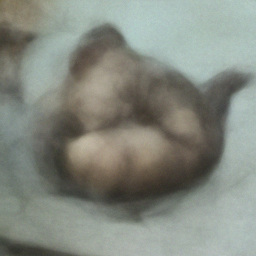

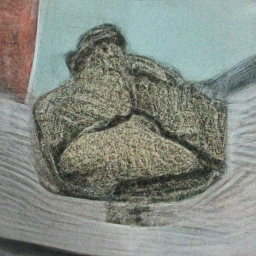

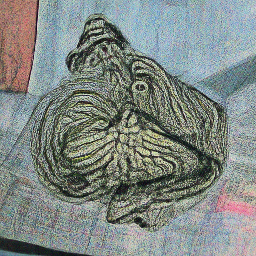

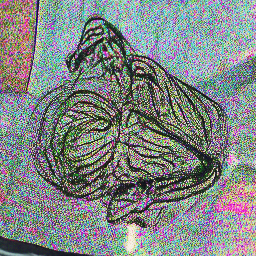

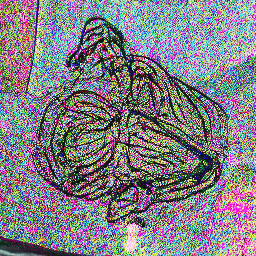

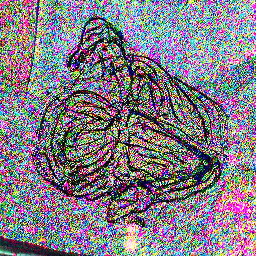

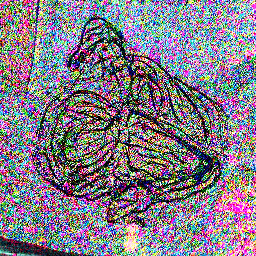

Saved 11 total images from guided diffusion to outputs/An_image_of_a_mushroom_MIN_the_color_green)


In [ ]:
#@title Run
##############################
# Imports
##############################
from pathlib import Path

import kornia.augmentation as kaugs
import torch as th
from tqdm.auto import tqdm
from IPython import display as ipy_display

from cgd import clip_guided_diffusion
import cgd_util

##############################
# Config
##############################

prompt = "An image of a mushroom"  #@param{type: "string"}

prompt_min = "the color green"  #@param{type: "string"}
prompt_min = None if len(prompt_min) == 0 else prompt_min
min_weight = 0.1  #@param{type: "number"}

tv_scale = 100 #@param{type: "number"}

#@markdown `class_score` Rank classes with CLIP instead of uniform random selection
class_score = True #@param{type: "boolean"}
top_n = 100  #@param{type: "number"}

output_dir = "outputs"  #@param {type: "string"}
output_dir = Path(output_dir)

save_frequency = 25  #@param {type: "number"}

batch_size = 1  #@param{type: "number"}
image_size = 256  #@param{type: "number"}

#@markdown `timestep_respacing` - Number of timesteps to visit out of total `diffusion_steps`.
#@markdown  - Smaller values are much faster but less accurate.
#@markdown  - Larger values are very accurate but take much longer.
timestep_respacing = "250"  #@param{type:"string"}

#@markdown `init_image` - Sample image for `skip_timsteps` before guiding with CLIP.
#@markdown `skip_timesteps` should be less than `timestep_respacing` and `diffusion_steps`
skip_timesteps = 0  #@param{type:"number"}
init_image = ""  #@param{type: "string"}
init_image = None if len(init_image) == 0 else init_image

checkpoints_dir = Path("checkpoints")
checkpoints_dir.mkdir(exist_ok=True)

#@markdown disabling class_cond will also disable class randomization/clip scoring
class_cond = True  #@param{type: "boolean"}
clip_guidance_scale = 1000  #@param {type: "number"}

#@markdown cutout power can be decreased with sufficiently high num_cutouts
cutout_power = 1.0  #@param{type: "number"}
num_cutouts = 16  #@param{type: "number"}
seed = 0  #@param{type: "number"}
diffusion_steps = 1000  #@param{type:"number"}
clip_model_name = "ViT-B/32"  #@param{type: "string"}

# I have not experimented with transforms much; these are merely here to showcase how to use them.
random_affine = False #@param{type: "boolean"}
random_motion_blur = False #@param{type: "boolean"}
random_horizontal_flip = False #@param{type: "boolean"}

augs = []
if random_affine:
    augs.append(kaugs.RandomAffine(degrees=0, translate=(
        0.1, 0.1), scale=(0.9, 1.1), shear=0.1))
if random_motion_blur:
    augs.append(kaugs.RandomMotionBlur(
        kernel_size=(1, 5), angle=15, direction=0.5))
if random_horizontal_flip:
    augs.append(kaugs.RandomHorizontalFlip(p=0.5))

##############################
# Actually do the run...
##############################
clear_scrollback = False  #@param {type: "string"}

assert 0 < save_frequency <= int(timestep_respacing.replace('ddim', '')), \
    "--save_frequency/--freq must be greater than 0and less than --timestep_respacing"

# convert Path arg to Path object
prefix_path = Path('./outputs')
prefix_path.mkdir(exist_ok=True)
assert prefix_path.is_dir(
), f"--prefix,-dir {prefix_path} is a file, not a directory. Please provide a directory."

# Initialize diffusion generator
cgd_samples, _, diffusion = clip_guided_diffusion(
    prompt=prompt, prompt_min=prompt_min, min_weight=min_weight, batch_size=batch_size, tv_scale=tv_scale, top_n=top_n,
    image_size=image_size, class_cond=class_cond, clip_guidance_scale=clip_guidance_scale, cutout_power=cutout_power,
    num_cutouts=num_cutouts, timestep_respacing=timestep_respacing, custom_device='cuda' if th.cuda.is_available() else 'cpu',
    seed=seed, diffusion_steps=diffusion_steps, skip_timesteps=skip_timesteps, init_image=init_image, checkpoints_dir=checkpoints_dir,
    clip_model_name=clip_model_name, class_score=class_score,
)


# Remove non-alphanumeric and white space characters from prompt and prompt_min for directory name
outputs_path = cgd_util.txt_to_dir(base_path=prefix_path, txt=prompt, txt_min=prompt_min)
outputs_path.mkdir(exist_ok=True)

all_images = []
try:
    current_timestep = diffusion.num_timesteps - 1
    for step, sample in enumerate(cgd_samples):
        current_timestep -= 1
        if step % save_frequency == 0 or current_timestep == -1:
            for j, image in enumerate(sample["pred_xstart"]):
                image_path = Path(cgd_util.log_image(image, prefix_path, step, j))
                ipy_display.display(ipy_display.Image("current.png"))
                all_images.append(image_path)
            if clear_scrollback:
                ipy_display.clear_output()
except RuntimeError as runtime_ex:
    if "CUDA out of memory" in str(runtime_ex):
        tqdm.write(f"CUDA OOM error occurred.")
        tqdm.write(f"Try lowering --image_size/-size, --batch_size/-bs, --num_cutouts/-cutn")
        tqdm.write(f"--clip_model/-clip (currently '{clip_model_name}') can have a large impact on VRAM usage.")
        tqdm.write(f"RN50 will use the least VRAM. ViT-B/32 is the best bang for your buck.")
        tqdm.write(f"(colab) Restart the runtime. This is required upon rerunning cells due to a memory leak.")
        # Seems to be a memory leak specific to ipython/jupyter/pytorch
        # If you're rerunning this cell, you may need to restart the runtime.
    else:
        raise runtime_ex

print(f"Saved {len(all_images)} total images from guided diffusion to {outputs_path})")